In [16]:
import pandas as pd
import numpy as np

def process_gesture_data(file_path):
    # 读取 CSV 文件
    df = pd.read_csv(file_path, header=None)
    
    # 移除第一列（时间列无用）
    df = df.iloc[:, 1:].reset_index(drop=True)
    
    # 识别手势分割行（全 0 行）
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    # 分割手势数据
    gestures = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:  # 确保包含最后一个手势
        if start_idx < idx:  # 避免连续空行导致空片段
            gestures.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    
    processed_gestures = []
    
    for i, gesture in enumerate(gestures):
        data = gesture.to_numpy()
        print(f"Processing Gesture {i+1} with {data.shape[0]} samples")
        
        # 如果数据多于1000，直接截断
        if data.shape[0] > 1000:
            data = data[:1000]
        
        # 插值到 1000 采样点（如果不足）
        if data.shape[0] < 1000:
            x_old = np.linspace(0, 1, data.shape[0])
            x_new = np.linspace(0, 1, 1000)
            data = np.array([np.interp(x_new, x_old, data[:, j]) for j in range(data.shape[1])]).T
        
        # 切分窗口：100 个点一个窗口，步长 50
        windows = []
        for start in range(0, 1000 - 100 + 1, 50):
            windows.append(data[start:start + 100])
        
        # 转换成 [1, window_num, 100, 10]
        windows = np.array(windows)
        windows = np.expand_dims(windows, axis=0)  # 额外的 batch 维度
        
        # 记录手势编号
        gesture_id = np.full((1, windows.shape[1], 100, 1), i + 1)  # 手势编号从 1 开始
        windows = np.concatenate((gesture_id, windows), axis=-1)  # 拼接到第一个通道
        
        # 存储到列表
        processed_gestures.append(windows)
    
    # 合并所有手势数据
    final_data = np.concatenate(processed_gestures, axis=0)  # [gesture_count, window_num, 100, 11]
    return final_data


In [17]:
# 示例调用
file_path = r"new_collect\fzh\sensor_data4.csv"
gesture_data = process_gesture_data(file_path)
print("Final data shape:", gesture_data.shape)

Detected empty rows at indices: [999, 2009, 3016, 4023]
Processing Gesture 1 with 999 samples
Processing Gesture 2 with 1009 samples
Processing Gesture 3 with 1006 samples
Processing Gesture 4 with 1006 samples
Final data shape: (4, 19, 100, 11)


# visualization

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_gesture_data(file_path):
    # 读取 CSV 文件
    df = pd.read_csv(file_path, header=None)
    
    # 移除第一列（时间列无用）
    df = df.iloc[:, 1:].reset_index(drop=True)
    
    # 识别手势分割行（全 0 行）
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    # 分割手势数据
    gestures = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:  # 确保包含最后一个手势
        if start_idx < idx:  # 避免连续空行导致空片段
            gestures.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    
    # 计算行列数
    num_gestures = len(gestures)
    cols = 2  # 每行 2 个图
    rows = (num_gestures + cols - 1) // cols  # 计算需要的行数
    
    # 创建图形
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()
    
    # 仅绘制一次图例
    legend_labels = [f'Channel {j+1}' for j in range(gestures[0].shape[1])]
    
    for i, gesture in enumerate(gestures):
        data = gesture.to_numpy()
        print(f"Processing Gesture {i+1} with {data.shape[0]} samples")
        
        # 画每个手势的所有通道数据
        for j in range(data.shape[1]):
            axes[i].plot(data[:, j])
        
        axes[i].set_title(f'Gesture {i+1}')
        axes[i].set_xlabel('Samples')
        axes[i].set_ylabel('Sensor Values')
    
    # 在最后一个子图上添加图例
    axes[-1].legend(legend_labels, loc='upper right')
    
    # 移除多余的子图
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


Detected empty rows at indices: [997, 2004, 3011, 4021, 5027, 6035, 7047, 8060, 9071, 10081, 11091, 12099, 13106, 14109, 15119, 16125, 17137, 18144, 19154, 20164, 21172, 22183, 23193, 24204, 25210]
Processing Gesture 1 with 997 samples
Processing Gesture 2 with 1006 samples
Processing Gesture 3 with 1006 samples
Processing Gesture 4 with 1009 samples
Processing Gesture 5 with 1005 samples
Processing Gesture 6 with 1007 samples
Processing Gesture 7 with 1011 samples
Processing Gesture 8 with 1012 samples
Processing Gesture 9 with 1010 samples
Processing Gesture 10 with 1009 samples
Processing Gesture 11 with 1009 samples
Processing Gesture 12 with 1007 samples
Processing Gesture 13 with 1006 samples
Processing Gesture 14 with 1002 samples
Processing Gesture 15 with 1009 samples
Processing Gesture 16 with 1005 samples
Processing Gesture 17 with 1011 samples
Processing Gesture 18 with 1006 samples
Processing Gesture 19 with 1009 samples
Processing Gesture 20 with 1009 samples
Processing G

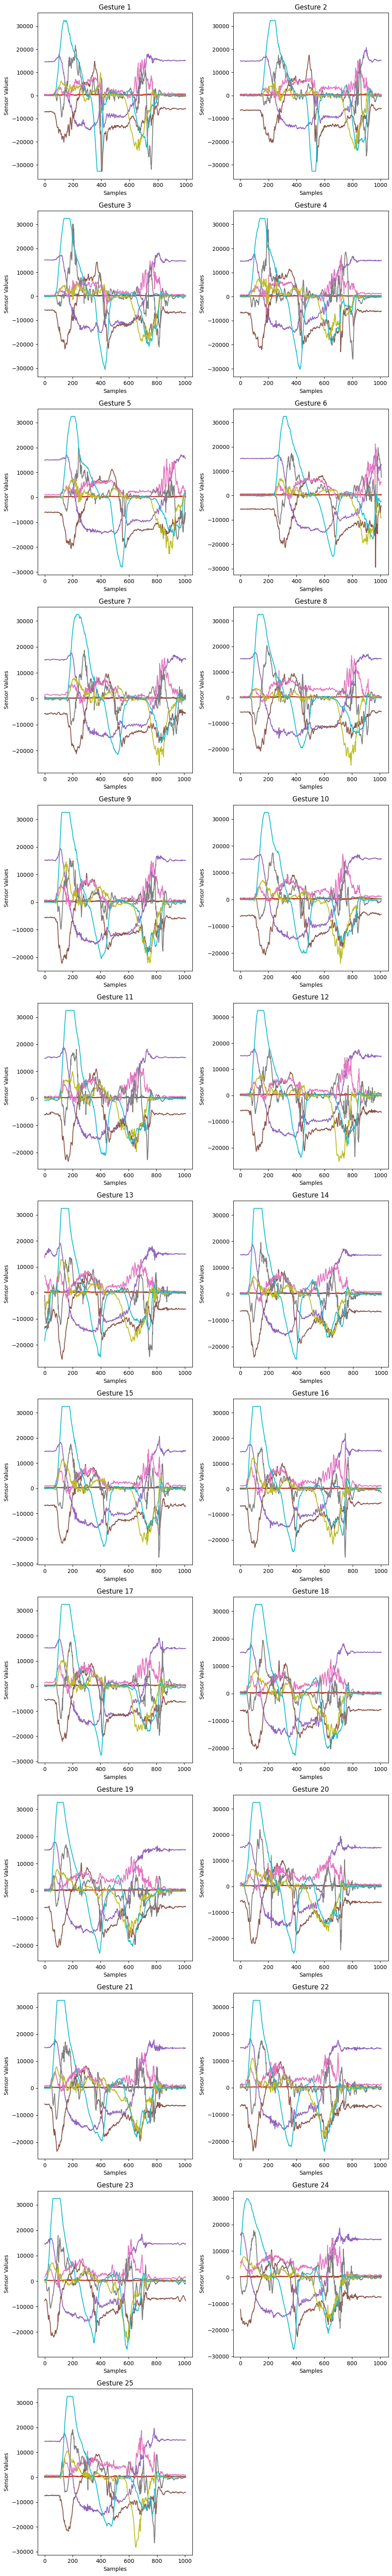

In [74]:
# 示例调用
file_path = r"new_collect\fzh\sensor_data1.csv"
visualize_gesture_data(file_path)

# visualizaion 2 for EMG 

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_gesture_data(file_path1, file_path2):
    # 读取 CSV 文件
    df = pd.read_csv(file_path1, header=None)
    
    # 移除第一列（时间列无用）
    df = df.iloc[:, 1:].reset_index(drop=True)
    
    # 识别手势分割行（全 0 行）
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    # 分割手势数据
    gesture1 = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:  # 确保包含最后一个手势
        if start_idx < idx:  # 避免连续空行导致空片段
            gesture1.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1

    # df2 = pd.read_csv(file_path2, header=None)
    # df2 = df2.iloc[:, 1:2].reset_index(drop=True)
    # empty_rows2 = df2[(df2 == 0).all(axis=1)].index.tolist()
    # print(f"Detected empty rows at indices: {empty_rows2}")
    
    # # 分割手势数据
    # gestures2 = []
    # start_idx = 0
    # for idx in empty_rows2 + [len(df2)]:  # 确保包含最后一个手势
    #     if start_idx < idx:  # 避免连续空行导致空片段
    #         gestures2.append(df2.iloc[start_idx:idx].reset_index(drop=True))
    #     start_idx = idx + 1



    # 计算行列数
    num_gestures = len(gesture1)
    cols = 2  # 每行 2 个图
    rows = (num_gestures + cols - 1) // cols  # 计算需要的行数
    
    # 创建图形
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()
    
    # 仅绘制一次图例
    legend_labels = [f'Channel {j+1}' for j in range(gesture1[0].shape[1])]
    
    for i, gesture in enumerate(gesture1):
        data = gesture1.to_numpy()
        print(f"Processing Gesture {i+1} with {data.shape[0]} samples")
        
        # 画每个手势的所有通道数据
        for j in range(data.shape[1]):
            axes[i].plot(data[:, j])
        
        axes[i].set_title(f'Gesture {i+1}')
        axes[i].set_xlabel('Samples')
        axes[i].set_ylabel('Sensor Values')
    
    # 在最后一个子图上添加图例
    axes[0].legend(legend_labels, loc='upper right')
    
    # 移除多余的子图
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


Detected empty rows at indices: [997, 2004, 3011, 4021, 5027, 6035, 7047, 8060, 9071, 10081, 11091, 12099, 13106, 14109, 15119, 16125, 17137, 18144, 19154, 20164, 21172, 22183, 23193, 24204, 25210]


AttributeError: 'list' object has no attribute 'to_numpy'

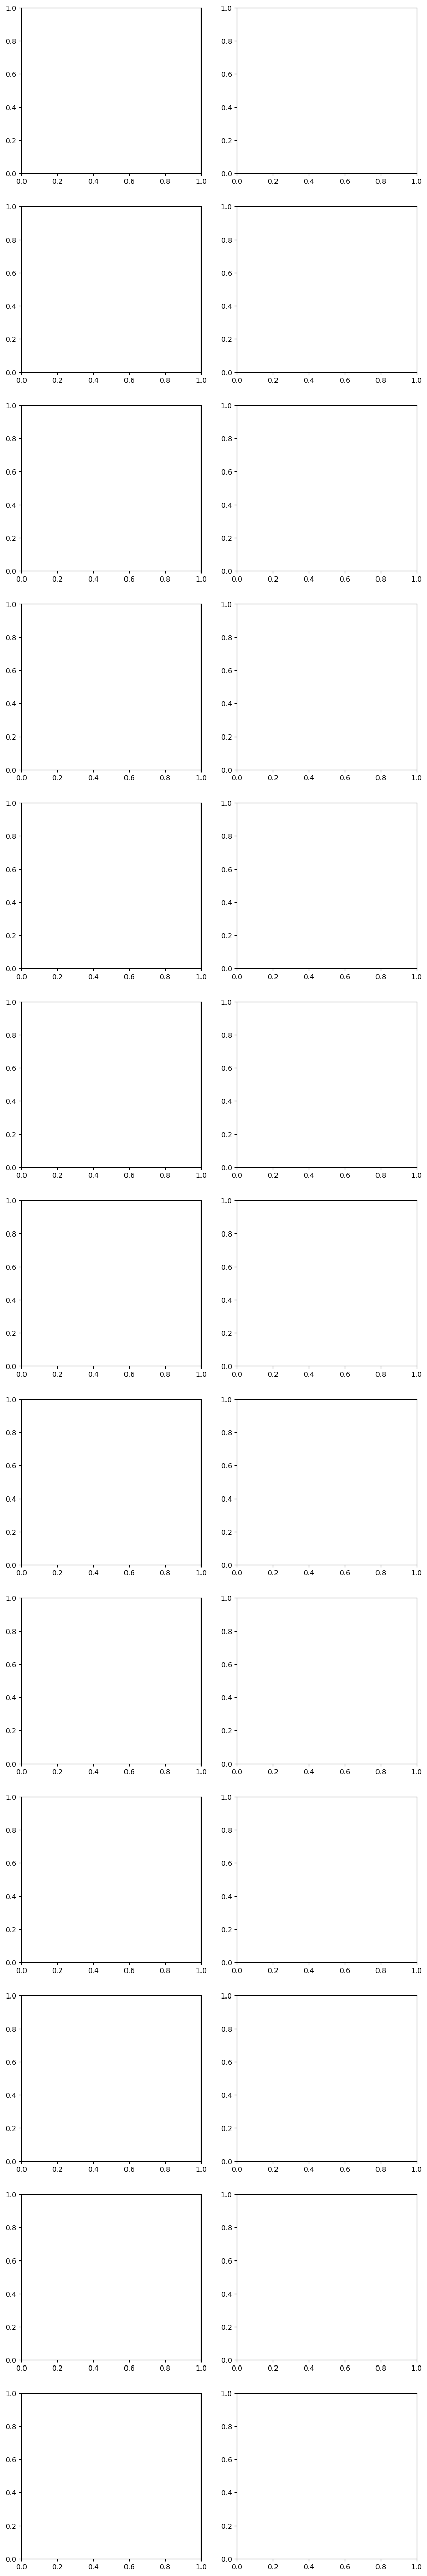

In [84]:
# 示例调用
file_path1 = r"new_collect\fzh\sensor_data1.csv"
file_path2 = r"new_collect\fzh\sensor_data2.csv"
visualize_gesture_data(file_path1,file_path2)

In [122]:
import os
import re
import pandas as pd
import numpy as np

def process_gesture_data(file_path):
    df = pd.read_csv(file_path, header=None)
    df = df.iloc[:, 1:].reset_index(drop=True)  # 移除时间列
    
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    gestures = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:
        if start_idx < idx:
            gestures.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    processed_gestures = []
    for i, gesture in enumerate(gestures):
        data = gesture.to_numpy()
        # print(f"Processing Trial {i+1} of Gesture with {data.shape[0]} samples")
        if data.shape[0] > 1000:
            data = data[:1000]
        if data.shape[0] < 1000:
            x_old = np.linspace(0, 1, data.shape[0])
            x_new = np.linspace(0, 1, 1000)
            data = np.array([np.interp(x_new, x_old, data[:, j]) for j in range(data.shape[1])]).T
        
        windows = []
        for start in range(0, 1000 - 100 + 1, 50):
            windows.append(data[start:start + 100])
        
        windows = np.array(windows)
        windows = np.expand_dims(windows, axis=0)
        gesture_id = np.full((1, windows.shape[1], 100, 1), i + 1)
        windows = np.concatenate((gesture_id, windows), axis=-1)
        processed_gestures.append(windows[:,:,:,1:])
    
    final_data = np.concatenate(processed_gestures, axis=0)
    return final_data

def process_all_gesture_files(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    all_files = sorted(all_files, key=lambda x: int(re.search(r"sensor_data(\d+).csv", x).group(1)))
    all_files = [os.path.join(folder_path, f) for f in all_files]
    
    all_data = []
    all_labels = []
    
    for label, file_path in enumerate(all_files, start=1):
        print(f"Processing {file_path} with label {label}")
        data = process_gesture_data(file_path)
        # data[:, :, :, 0] = label  # 设置第一个通道为文件对应的标签
        all_data.append(data)
        all_labels.append(np.full((data.shape[0],), label))
    
    final_dataset = np.concatenate(all_data, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)
    data_path = os.path.join(folder_path,"processed_gesture_data.npy")
    label_path = os.path.join(folder_path, "gesture_labels.npy")
    np.save(data_path, final_dataset)
    np.save(label_path, final_labels)
    print("Processed data and labels saved.")
    
    return final_dataset, final_labels



In [123]:
folder_path = r"new_collect\fzh"  
final_data, final_labels = process_all_gesture_files(folder_path)
print("Final data shape:", final_data.shape)
print("Final labels shape:", final_labels.shape)

Processing new_collect\fzh\sensor_data1.csv with label 1
Detected empty rows at indices: [997, 2004, 3011, 4021, 5027, 6035, 7047, 8060, 9071, 10081, 11091, 12099, 13106, 14109, 15119, 16125, 17137, 18144, 19154, 20164, 21172, 22183, 23193, 24204, 25210]
Processing new_collect\fzh\sensor_data2.csv with label 2
Detected empty rows at indices: [998, 2005, 3012, 4022, 5029, 6039, 7052, 8062, 9069, 10076, 11087, 12094, 13101, 14106, 15113, 16123, 17130, 18140, 19153, 20164, 21171, 22181, 23189, 24196, 25199]
Processed data and labels saved.
Final data shape: (50, 19, 100, 10)
Final labels shape: (50,)


In [121]:
final_data[0,0,0,0]

312.0

In [119]:
print(final_data.shape)
final_labels

(50, 19, 100, 10)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

In [124]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_path, test_size=0.1, random_state=42):
    """
    加载预处理的手势数据，并拆分为训练集和测试集。
    
    参数：
    root_path (str): 存储 processed_gesture_data.npy 和 gesture_labels.npy 的根目录
    test_size (float): 测试集比例，默认 20%
    random_state (int): 随机种子，确保可复现性
    
    返回：
    X_train, X_test, y_train, y_test: 训练集和测试集的数据及标签
    """
    data_path = os.path.join(root_path, "processed_gesture_data.npy")
    label_path = os.path.join(root_path, "gesture_labels.npy")
    
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
    print("Loading processed data...")
    X = np.load(data_path,allow_pickle=True)
    y = np.load(label_path,allow_pickle=True)
    
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test


In [125]:
data_folder = r"new_collect\fzh"  
X_train, X_test, y_train, y_test = load_data(data_folder)

Loading processed data...
Data shape: (50, 19, 100, 10), Labels shape: (50,)
Training set: (45, 19, 100, 10), Testing set: (5, 19, 100, 10)
